In [1]:
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm

In [2]:
eeg_task_path = '../Data/Processed/sub01_binned_task_raw.csv'
eeg_data = pd.read_csv(eeg_task_path)

In [3]:
selected_electrodes = [
    'O1', 'O2', 'Oz', 'POz', 'PO3', 'PO4', 'PO7', 'PO8',
    'F3', 'F4', 'Fz', 'F7', 'F8', 'AF3', 'AF4', 'AF7', 'AF8', 'Fpz',
    'T7', 'T8', 'Cz', 'Pz', 'FCz', 'CP1', 'CP2'
]

In [4]:
class EEGDataset(Dataset):
    def __init__(self, eeg_data):
        self.eeg_data = eeg_data
        self.X, self.y = self.preprocess_data()

    def preprocess_data(self):
        X = []
        y = []
        for idx, row in self.eeg_data.iterrows():
            trial_data = []
            for electrode in selected_electrodes:
                # Convert string representation to list of floats
                signal = np.array(ast.literal_eval(row[electrode]))
                trial_data.append(signal)
            
            # Stack the signals from each electrode (shape: n_channels, n_time_points)
            X.append(np.array(trial_data))
            y.append(1 if row['label_type'] == 'social' else 0)
        
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

In [5]:
eeg_dataset = EEGDataset(eeg_data)
train_size = int(0.7 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class EEGCNN(nn.Module):
    def __init__(self, n_channels=25, n_time_points=1024, n_classes=2):
        super(EEGCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(n_channels, 5), stride=1)
        self.pool1 = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 5), stride=1)
        self.pool2 = nn.MaxPool2d((1, 2))

        # Compute the size of the flattened output dynamically
        self.flattened_size = self._get_flattened_size(n_channels, n_time_points)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, n_classes)
    
    def _get_flattened_size(self, n_channels, n_time_points):
        """Compute the flattened size after the convolutional and pooling layers."""
        dummy_input = torch.zeros(1, 1, n_channels, n_time_points)  # (batch_size, channels, height, width)
        x = self.pool1(F.relu(self.conv1(dummy_input)))
        x = self.pool2(F.relu(self.conv2(x)))
        return x.numel()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, n_channels, n_time_points)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
model = EEGCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
def train(model, train_loader, num_epochs=10):
    model.train()
    train_losses = []  # List to store loss values for plotting

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as pbar:
            for X_batch, y_batch in pbar:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                # Accumulate the loss
                epoch_loss += loss.item()
                
                # Update tqdm description with current batch loss
                pbar.set_postfix({'Batch Loss': loss.item()})

        # Calculate and store the average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    return train_losses

In [9]:
train_losses = train(model, train_loader, num_epochs=30)

Epoch 1/30: 100%|██████████| 7/7 [00:00<00:00, 43.83batch/s, Batch Loss=0.689]


Epoch 1/30, Avg Loss: 0.7087


Epoch 2/30: 100%|██████████| 7/7 [00:00<00:00, 117.38batch/s, Batch Loss=0.67]


Epoch 2/30, Avg Loss: 0.6963


Epoch 3/30: 100%|██████████| 7/7 [00:00<00:00, 117.54batch/s, Batch Loss=0.675]


Epoch 3/30, Avg Loss: 0.6961


Epoch 4/30: 100%|██████████| 7/7 [00:00<00:00, 101.50batch/s, Batch Loss=0.698]


Epoch 4/30, Avg Loss: 0.6959


Epoch 5/30: 100%|██████████| 7/7 [00:00<00:00, 110.84batch/s, Batch Loss=0.689]


Epoch 5/30, Avg Loss: 0.6957


Epoch 6/30: 100%|██████████| 7/7 [00:00<00:00, 117.88batch/s, Batch Loss=0.677]


Epoch 6/30, Avg Loss: 0.6955


Epoch 7/30: 100%|██████████| 7/7 [00:00<00:00, 118.42batch/s, Batch Loss=0.674]


Epoch 7/30, Avg Loss: 0.6953


Epoch 8/30: 100%|██████████| 7/7 [00:00<00:00, 118.94batch/s, Batch Loss=0.712]


Epoch 8/30, Avg Loss: 0.6952


Epoch 9/30: 100%|██████████| 7/7 [00:00<00:00, 120.56batch/s, Batch Loss=0.697]


Epoch 9/30, Avg Loss: 0.6951


Epoch 10/30: 100%|██████████| 7/7 [00:00<00:00, 115.45batch/s, Batch Loss=0.689]


Epoch 10/30, Avg Loss: 0.6949


Epoch 11/30: 100%|██████████| 7/7 [00:00<00:00, 117.29batch/s, Batch Loss=0.716]


Epoch 11/30, Avg Loss: 0.6949


Epoch 12/30: 100%|██████████| 7/7 [00:00<00:00, 116.35batch/s, Batch Loss=0.683]


Epoch 12/30, Avg Loss: 0.6947


Epoch 13/30: 100%|██████████| 7/7 [00:00<00:00, 99.41batch/s, Batch Loss=0.705]


Epoch 13/30, Avg Loss: 0.6946


Epoch 14/30: 100%|██████████| 7/7 [00:00<00:00, 118.13batch/s, Batch Loss=0.678]


Epoch 14/30, Avg Loss: 0.6945


Epoch 15/30: 100%|██████████| 7/7 [00:00<00:00, 119.38batch/s, Batch Loss=0.698]


Epoch 15/30, Avg Loss: 0.6943


Epoch 16/30: 100%|██████████| 7/7 [00:00<00:00, 117.23batch/s, Batch Loss=0.687]


Epoch 16/30, Avg Loss: 0.6942


Epoch 17/30: 100%|██████████| 7/7 [00:00<00:00, 119.64batch/s, Batch Loss=0.688]


Epoch 17/30, Avg Loss: 0.6942


Epoch 18/30: 100%|██████████| 7/7 [00:00<00:00, 117.15batch/s, Batch Loss=0.703]


Epoch 18/30, Avg Loss: 0.6941


Epoch 19/30: 100%|██████████| 7/7 [00:00<00:00, 116.75batch/s, Batch Loss=0.705]


Epoch 19/30, Avg Loss: 0.6941


Epoch 20/30: 100%|██████████| 7/7 [00:00<00:00, 116.42batch/s, Batch Loss=0.697]


Epoch 20/30, Avg Loss: 0.6940


Epoch 21/30: 100%|██████████| 7/7 [00:00<00:00, 99.70batch/s, Batch Loss=0.697]


Epoch 21/30, Avg Loss: 0.6939


Epoch 22/30: 100%|██████████| 7/7 [00:00<00:00, 117.10batch/s, Batch Loss=0.688]


Epoch 22/30, Avg Loss: 0.6938


Epoch 23/30: 100%|██████████| 7/7 [00:00<00:00, 116.19batch/s, Batch Loss=0.695]


Epoch 23/30, Avg Loss: 0.6938


Epoch 24/30: 100%|██████████| 7/7 [00:00<00:00, 119.53batch/s, Batch Loss=0.689]


Epoch 24/30, Avg Loss: 0.6938


Epoch 25/30: 100%|██████████| 7/7 [00:00<00:00, 121.88batch/s, Batch Loss=0.698]


Epoch 25/30, Avg Loss: 0.6937


Epoch 26/30: 100%|██████████| 7/7 [00:00<00:00, 119.07batch/s, Batch Loss=0.696]


Epoch 26/30, Avg Loss: 0.6936


Epoch 27/30: 100%|██████████| 7/7 [00:00<00:00, 118.74batch/s, Batch Loss=0.693]


Epoch 27/30, Avg Loss: 0.6936


Epoch 28/30: 100%|██████████| 7/7 [00:00<00:00, 116.82batch/s, Batch Loss=0.69]


Epoch 28/30, Avg Loss: 0.6936


Epoch 29/30: 100%|██████████| 7/7 [00:00<00:00, 112.69batch/s, Batch Loss=0.696]


Epoch 29/30, Avg Loss: 0.6935


Epoch 30/30: 100%|██████████| 7/7 [00:00<00:00, 107.52batch/s, Batch Loss=0.693]

Epoch 30/30, Avg Loss: 0.6935


In [10]:
def plot_loss_curve(losses):
    """Plot the training loss curve."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

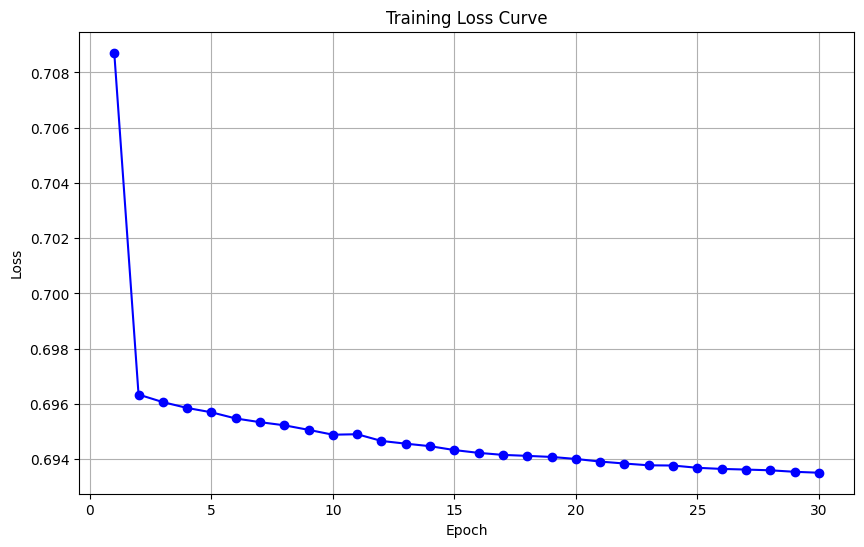

In [11]:
plot_loss_curve(train_losses)

In [12]:
def evaluate(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(y_batch.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_true, y_pred))

In [13]:
evaluate(model, test_loader)

Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.50      1.00      0.67        48

    accuracy                           0.50        96
   macro avg       0.25      0.50      0.33        96
weighted avg       0.25      0.50      0.33        96



c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\omarh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [16]:
def plot_topomap(model, eeg_data):
    # Extract feature importance from the fully connected layer
    feature_importances = model.fc1.weight.detach().numpy().mean(axis=0)
    feature_importances = np.abs(feature_importances)

    # Create a dictionary of feature importance for each electrode
    electrode_importances = {electrode: feature_importances[i] for i, electrode in enumerate(selected_electrodes)}
    
    # Create an MNE info object with the 10-20 system montage
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=selected_electrodes, sfreq=512, ch_types='eeg')
    info.set_montage(montage)
    
    # Create an array with the feature importances for the selected electrodes
    importance_array = np.array([electrode_importances.get(ch, 0) for ch in selected_electrodes])
    
    # Plot the topographical map with a colorbar
    fig, ax = plt.subplots()
    im, _ = mne.viz.plot_topomap(importance_array, info, axes=ax, cmap='viridis', show=False)
    
    # Add a colorbar to the plot
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Feature Importance')

    plt.title('Topographical Map of Electrode Importances')
    plt.show()

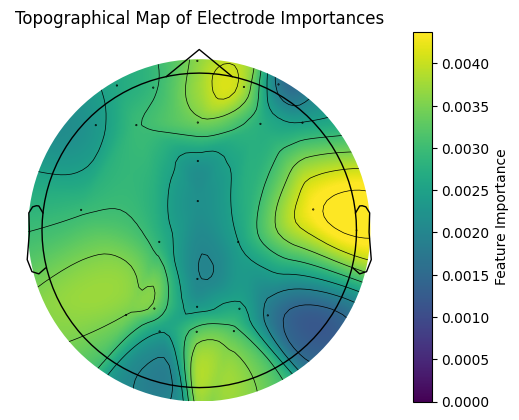

In [17]:
plot_topomap(model, eeg_data)